#TFM - Análisis de la evolución de noticias falsas en Twitter

##Fase 02 - Texto a Números

En esta fase trataremos de procesar el texto de los tweets y pasarlos por el modelo para adquirir los Embeddings. 
También trataremos de localizar el tweet más antiguo que hable de esta noticia falsa.


##Fuentes
###Sentence-BERT
- [Sentence Embeddings with BERT & XLNet](https://pythonrepo.com/repo/UKPLab-sentence-transformers-python-natural-language-processing)
- [Quickstart Sentence-BERT](https://www.sbert.net/docs/quickstart.html)
- [Pretrained Models](https://www.sbert.net/docs/pretrained_models.html)

###BERT Analisis Twitter
- [How I used Bidirectional Encoder Representations from Transformers (BERT) to Analyze Twitter Data](https://analyticsindiamag.com/how-i-used-bidirectional-encoder-representations-from-transformers-bert-to-analyze-twitter-data/)
- [Hands-On Guide to Download, Analyze and Visualize Twitter Data](https://analyticsindiamag.com/hands-on-guide-to-download-analyze-and-visualize-twitter-data/)
- [Guide To Pysentimiento Toolkit | Text Classification Using Transformers](https://analyticsindiamag.com/guide-to-pysentimiento-toolkit-text-classification-using-transformers)
- [Sentence Embeddings with BERT & XLNet](https://pythonrepo.com/repo/UKPLab-sentence-transformers-python-natural-language-processing)
- [Semantic Textual Similarity](https://www.sbert.net/docs/usage/semantic_textual_similarity.html)
- [Computing Sentence Embeddings](https://www.sbert.net/examples/applications/computing-embeddings/README.html)

###Sentence-bert model spanish texts
- [Multi-Lingual Models](https://www.sbert.net/docs/pretrained_models.html)
- [BETO: Spanish BERT](https://medium.com/dair-ai/beto-spanish-bert-420e4860d2c6)
- [BETO: Spanish BERT on GitHub](https://github.com/dccuchile/beto)

@inproceedings{CaneteCFP2020,
  title={Spanish Pre-Trained BERT Model and Evaluation Data},
  author={Cañete, José and Chaperon, Gabriel and Fuentes, Rodrigo and Ho, Jou-Hui and Kang, Hojin and Pérez, Jorge},
  booktitle={PML4DC at ICLR 2020},
  year={2020}
}

###Embedints (Incrustaciones de palabras)
- [El modelo Embeddings (Incrustaciones) de Palabras](https://unipython.com/el-modelo-embeddings-incrustaciones-de-palabras/)

###Calculo de distancias
- [scipy.spatial.distance.cosine](https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.distance.cosine.html)
- [Cosine Similarity – Understanding the math and how it works (with python codes)](https://www.machinelearningplus.com/nlp/cosine-similarity/)
- [Document Similarity](https://shravan-kuchkula.github.io/document_similarity/#)
- [Semantic Textual Similarity](https://www.sbert.net/docs/usage/semantic_textual_similarity.html)

###CSV
- [CSV File Reading and Writing](https://docs.python.org/3/library/csv.html)

###Helps on development
- https://stackoverflow.com/questions/62710872/how-to-store-word-vector-embeddings
- https://stackoverflow.com/questions/66537949/convert-twitter-new-date-format-to-date-time-y-m-d-hms
- https://stackoverflow.com/questions/8200342/removing-duplicate-strings-from-a-list-in-python



In [ ]:
#################################################
# install the sentence-transformers
#################################################
#Required libs on installs
import datetime #Work with dates
import sys

if 'sentence-transformers' in sys.modules:
    print(f"{'sentence-transformers'!r} already in sys.modules")
else:
    # install the sentence-transformers
    !pip install -U sentence-transformers


print('\n\nInstalación realizada a las ', datetime.datetime.now().strftime("%d %b %Y - %H:%M:%S"),'...')



Instalación realizada a las  25 Oct 2021 - 09:15:05 ...


In [ ]:
#################################################
# Importing Libraries
#################################################
# Importing Sentence Transformers Library to get model after
from sentence_transformers import SentenceTransformer, util

# Needed to create/load jsons file with tweets 
import json

# Numpy (here we go to use it for store/load embeddings on cloud)
import numpy as np

#google drive
from google.colab import drive

import os
import pandas as pd
import math

import importlib.util

from datetime import datetime as datetime_parser #Parse string dates
print('Librerias cargadas a las ', datetime.datetime.now().strftime("%d %b %Y - %H:%M:%S"),'...')

Librerias cargadas a las  25 Oct 2021 - 09:15:35 ...


In [ ]:
######################################################
# Mount google drive and use folder of data
######################################################
drive.mount('/content/drive/')
BASE_FOLDER = '/content/drive/My Drive/Colab Notebooks/09_TFM/c_vieja_data/'



print('\nDRIVE montada a las ', datetime.datetime.now().strftime("%d %b %Y - %H:%M:%S"),'...')

Mounted at /content/drive/

DRIVE montada a las  25 Oct 2021 - 09:19:14 ...


In [ ]:
#################################################################
# Method that replace and remove Unicode chars
#
# https://en.wikipedia.org/wiki/List_of_Unicode_characters
# https://apps.timwhitlock.info/emoji/tables/unicode
#################################################################
def UnicodeFilter(var):
    temp = var
    temp = temp.replace(chr(0x0015), "'")
    temp = temp.replace(chr(0x2026), "")
    temp = temp.replace(chr(0x2015), " ")

    # Remove emojis and all that shit
    for x in range(127381, 129305):
        temp = temp.replace(chr(x), "")
    return str(temp)
#end_def

#DEBUG code
##print(chr(0x0015))
##print(chr(0x2026))
##print(chr(0x2019)) 
##for x in range(127381, 129305):
##    print(chr(x))

print('Método creado a las ', datetime.datetime.now().strftime("%d %b %Y - %H:%M:%S"),'...')

Método creado a las  25 Oct 2021 - 09:19:14 ...


In [ ]:
#################################################
# Method that makes a little processed of data in  
# order to get tweets text normalized for spanish 
# language
#
# TODO: can be improved
#################################################
def preprocess_tweets_text_v3(tweets_df):

    #Auxiliar dataframe
    aux_df = pd.DataFrame(columns=['tweet_id', 'created_at', 'text'])


    # Iterating the index
    for index, row in tweets_df.iterrows():
        try:
            ##print(row)

            ##the_text = tweets_df.loc[index, "text"]
            the_text = row.text
            proc_text = UnicodeFilter(the_text)
            ##print(proc_text)

            ##t_id = tweets_df.loc[index,'tweet_id']
            t_id = row.tweet_id
            ##print(t_id)

            ##when = tweets_df.loc[index,'created_at']
            when = row.created_at
            ##print(when)

            #Parse string date and convert to timestamp
            ##Mon Oct 04 00:34:33 +0000 2021
            when_ts = datetime_parser.strptime(when,'%a %b %d %H:%M:%S %z %Y')

            #Assign to new dataframe
            aux_df.loc[index] = [t_id, when_ts, proc_text]
        except Exception as e:
          msg = e
          print(msg)       
        #end_try      
    #end_for

    # get text list 
    sentences_processed_v2 = aux_df['text'].tolist()

    return aux_df, sentences_processed_v2
#end_def


print('Método creado a las ', datetime.datetime.now().strftime("%d %b %Y - %H:%M:%S"),'...')


Método creado a las  25 Oct 2021 - 09:19:14 ...


In [ ]:
#################################################
# Method that load tweets from JSON and store its
# into the dataframe
#
# TODO: can be improved
#################################################
def load_tweets_from_json(json_for_load, process_jsons):

    if process_jsons:
        ###########################################
        # Load JSON Tweets in a DataFrame
        with open(json_for_load) as f:
            data = json.load(f)
            ##print(data)

        #Json to Dataframe
        df = pd.DataFrame.from_dict(data, orient='columns')
        full_tweets_frame = df[["id","created_at","full_text","retweet_count","favorite_count"]]

        #Rename some columns
        full_tweets_frame.rename(columns={'id': 'tweet_id', 'full_text': 'text'}, inplace=True)

        # Show first N rows
        ##selected_columns.head(15)
  

        print('\nDatos cargados desde JSONs '+json_for_load+' a las ', datetime.datetime.now().strftime("%d %b %Y - %H:%M:%S"),'...')    

        return full_tweets_frame;
    else:
        print('\nNo working with data stored on JSONs')
    #end_if  
#end_method

In [ ]:
#################################################
# Tweets data load from JSONs on Dataframe
#################################################
if 'full_cumvieja_tweets_frame' in globals():
  del full_cumvieja_tweets_frame

if 'full_actualidad_tweets_frame' in globals():
  del full_actualidad_tweets_frame

if 'full_megatun_frame' in globals():
  del full_megatun_frame

if 'full_megatun_frame2' in globals():
  del full_megatun_frame2

if 'full_megatun_frame3' in globals():
  del full_megatun_frame3

if 'full_megatun_frame4' in globals():
  del full_megatun_frame4

###########################################
# Load Cumbre Vieja Tweets in a DataFrame
need2load_jsons = True
full_cumvieja_tweets_frame = load_tweets_from_json(BASE_FOLDER+'20211004_twits_cumbre_vieja.json', need2load_jsons)

###########################################
# Load actualidad/noticias/ciencia Tweets in a DataFrame
need2load_jsons = True
full_actualidad_tweets_frame = load_tweets_from_json(BASE_FOLDER+'20211008_tweets_actualidad.json', need2load_jsons)

###########################################
# Load Cumbre Vieja Tweets in a DataFrame
need2load_jsons = True
full_megatun_frame = load_tweets_from_json(BASE_FOLDER+'20210922_twits_Mega-Tsunami.json', need2load_jsons)

###########################################
# Load Megatsunami Tweets in a DataFrame
need2load_jsons = True
full_megatun_frame2 = load_tweets_from_json(BASE_FOLDER+'20210922_twits_megatsunami.json', need2load_jsons)

###########################################
# Load Megatsunami Tweets in a DataFrame
need2load_jsons = True
full_megatun_frame3 = load_tweets_from_json(BASE_FOLDER+'20211001_twits_Mega-Tsunami.json', need2load_jsons)

###########################################
# Load Megatsunami Tweets in a DataFrame
need2load_jsons = True
full_megatun_frame4 = load_tweets_from_json(BASE_FOLDER+'20211001_twits_megatsunami.json', need2load_jsons)

display('Numero total de tweets en df0: '+str(len(full_cumvieja_tweets_frame)))
display('Numero total de tweets en df1: '+str(len(full_actualidad_tweets_frame)))
display('Numero total de tweets en df2: '+str(len(full_megatun_frame)))
display('Numero total de tweets en df3: '+str(len(full_megatun_frame2)))
display('Numero total de tweets en df4: '+str(len(full_megatun_frame3)))
display('Numero total de tweets en df5: '+str(len(full_megatun_frame4)))

total = len(full_cumvieja_tweets_frame)+ len(full_actualidad_tweets_frame)+ len(full_megatun_frame) + len(full_megatun_frame2) + len(full_megatun_frame3)+ len(full_megatun_frame4)
display('Numero total de tweets a tratar: '+str(total))

print('\nTodos los datos cargados desde JSONs a las ', datetime.datetime.now().strftime("%d %b %Y - %H:%M:%S"),'...')    


/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,



Datos cargados desde JSONs /content/drive/My Drive/Colab Notebooks/09_TFM/c_vieja_data/20211004_twits_cumbre_vieja.json a las  25 Oct 2021 - 09:19:16 ...

Datos cargados desde JSONs /content/drive/My Drive/Colab Notebooks/09_TFM/c_vieja_data/20211008_tweets_actualidad.json a las  25 Oct 2021 - 09:19:17 ...

Datos cargados desde JSONs /content/drive/My Drive/Colab Notebooks/09_TFM/c_vieja_data/20210922_twits_Mega-Tsunami.json a las  25 Oct 2021 - 09:19:18 ...

Datos cargados desde JSONs /content/drive/My Drive/Colab Notebooks/09_TFM/c_vieja_data/20210922_twits_megatsunami.json a las  25 Oct 2021 - 09:19:19 ...

Datos cargados desde JSONs /content/drive/My Drive/Colab Notebooks/09_TFM/c_vieja_data/20211001_twits_Mega-Tsunami.json a las  25 Oct 2021 - 09:19:19 ...

Datos cargados desde JSONs /content/drive/My Drive/Colab Notebooks/09_TFM/c_vieja_data/20211001_twits_megatsunami.json a las  25 Oct 2021 - 09:19:20 ...


'Numero total de tweets en df0: 2000'

'Numero total de tweets en df1: 4000'

'Numero total de tweets en df2: 623'

'Numero total de tweets en df3: 535'

'Numero total de tweets en df4: 334'

'Numero total de tweets en df5: 1190'

'Numero total de tweets a tratar: 8682'


Todos los datos cargados desde JSONs a las  25 Oct 2021 - 09:19:20 ...


In [ ]:
####################################
# Merge all dataframes into one
####################################
if 'full_tweets_frame' in globals():
  del full_tweets_frame

full_tweets_frame = full_cumvieja_tweets_frame.append(full_actualidad_tweets_frame) ##pd.concat([full_cumvieja_tweets_frame,full_megatun_frame])    
full_tweets_frame = full_tweets_frame.append(full_megatun_frame) ##pd.concat([full_cumvieja_tweets_frame,full_megatun_frame])    
full_tweets_frame = full_tweets_frame.append(full_megatun_frame2) ##pd.concat([full_cumvieja_tweets_frame,full_megatun_frame])    
full_tweets_frame = full_tweets_frame.append(full_megatun_frame3) ##pd.concat([full_cumvieja_tweets_frame,full_megatun_frame])    
full_tweets_frame = full_tweets_frame.append(full_megatun_frame4) ##pd.concat([full_cumvieja_tweets_frame,full_megatun_frame])

display('Numero total de tweets en dataframe final: '+str(len(full_tweets_frame)))


#Remove previous dataframe in order to release memory and avoid problems
del full_cumvieja_tweets_frame
del full_actualidad_tweets_frame
del full_megatun_frame
del full_megatun_frame2
del full_megatun_frame3
del full_megatun_frame4


print('\nDatos mezclados en un único JSONs a las ', datetime.datetime.now().strftime("%d %b %Y - %H:%M:%S"),'...')   

'Numero total de tweets en dataframe final: 8682'


Datos mezclados en un único JSONs a las  25 Oct 2021 - 09:19:20 ...


In [ ]:
#################################################
# Review Dataframe tweets
#################################################
show_detailed_feedback = False

if show_detailed_feedback:
    full_tweets_frame.shape[0]
    full_tweets_frame[full_tweets_frame.columns[0]].count()
    display(full_tweets_frame.describe())
    display(full_tweets_frame.columns)


##full_tweets_frame.index.tolist()

In [ ]:
#################################################
# Tweets pre-procesing 1
#################################################

# PRE-PROCESS on own dataframe
# We add a column with tweet text char number
###full_tweets_frame['tweet_chars_number'] = full_tweets_frame['text'].str.len()

#REmoves duplicated tweets
drop_duplicates = True
if drop_duplicates:
  full_tweets_frame = full_tweets_frame.drop_duplicates(subset=['text'])
  display('Numero total de tweets tras eliminar repetidos: '+str(len(full_tweets_frame)))

# We add new column cosine score to the dataframe
###full_tweets_frame['cosine_scores'] = 0.0


# Show first N rows
###full_tweets_frame.head(15)

print('Tweets pre-procesing hecho a las ', datetime.datetime.now().strftime("%d %b %Y - %H:%M:%S"),'...')    


'Numero total de tweets tras eliminar repetidos: 3857'

Tweets pre-procesing hecho a las  25 Oct 2021 - 09:19:20 ...


In [ ]:
if show_detailed_feedback:
    # Show first N rows
    ##display(full_tweets_frame.head(-15))
    ##display(full_tweets_frame.head(-15).index.tolist())

    display(full_tweets_frame.iloc[2,0])
    display(full_tweets_frame.iloc[2,1])
    display(full_tweets_frame.iloc[2,2])
    display(full_tweets_frame.iloc[2,3])
    display(full_tweets_frame.iloc[2,4])
    display(full_tweets_frame.iloc[2,5])

In [ ]:
#################################################
# Tweets pre-procesing 2
#################################################

if 'full_tweets_frame_processed' in globals():
  del full_tweets_frame_processed

if 'preproc_txt' in globals():
  del preproc_txt

# PRE-PROCESS text
full_tweets_frame_processed, preproc_txt = preprocess_tweets_text_v3(full_tweets_frame)


#Sort tweets by his creation date    
full_tweets_frame_processed.sort_values('created_at', ascending=False, inplace=True)

#Reset index
##full_tweets_frame_processed.reset_index(drop=True, inplace=True)
##full_tweets_frame_processed.set_index('tweet_id', inplace=True)
full_tweets_frame_processed.reset_index(drop=True, inplace=True)

full_tweets_frame_processed['cosine_scores'] = 0.0

#
print(len(preproc_txt))
print(preproc_txt)

print('Tweets pre-procesing hecho a las ', datetime.datetime.now().strftime("%d %b %Y - %H:%M:%S"),'...')    


2772
["RT @rtve: No hay riesgo de 'megatsunami' en La Palma por la erupción\n\n#VerificaRTVE se fija en uno de los bulos más compartidos estos días", 'No hay riesgo de megatsunami en La Palma por la erupción, es un auténtico bulo, las personas deberían entender que detrás de los ordenadores hay todo tipo de loco, generando auténticas barbaridades.\n\nhttps://t.co/usMK489wA5 https://t.co/t2zZb7x3ox', 'Desde el principio de la pandemia todo es tan irreal que siento que estoy durmiendo y me voy a despertar en cualquier momento. En serio ahora alerta de mega tsunami?', "No hay riesgo de 'megatsunami' en La Palma por la erupción\n\n#VerificaRTVE se fija en uno de los bulos más compartidos estos días\n\nhttps://t.co/BBYDAqCPHZ", 'Joan Martí, el sabio de los volcanes: "La teoría del megatsunami es posible, aunque poco probable" https://t.co/v2t5C0258e via @elespanolcom', 'Tras 11 días, los pronósticos del estudio en La Palma por parte de  aseguradoras se está cumpliendo paso a paso.\n\nHabría

In [ ]:
#################################################
# Review Dataframe tweets
#################################################
show_detailed_feedback = False

display('Numero total de tweets: '+str(len(full_tweets_frame_processed)))

if show_detailed_feedback:
    full_tweets_frame_processed.shape[0]
    full_tweets_frame_processed[full_tweets_frame_processed.columns[0]].count()
    display(full_tweets_frame_processed.describe())
    display(full_tweets_frame_processed.columns)


##full_tweets_frame_processed.index.tolist()

'Numero total de tweets: 2772'

In [ ]:
#################################################
# Review Dataframe tweets
#################################################
# Show first N rows
full_tweets_frame_processed.head(15)

,tweet_id,created_at,text,cosine_scores
0,1446358160084774925,2021-10-08 06:13:52+00:00,@12_grados A pero es q se sigue viendo la tele...,0.0
1,1446357707016056844,2021-10-08 06:12:04+00:00,"☕ Coffee &amp; Mobility\nNoticias, análisis y ...",0.0
2,1446357682114412544,2021-10-08 06:11:58+00:00,RT @pinzasegunda: Y seguimos ¿Alguna duda de q...,0.0
3,1446357684677193733,2021-10-08 06:11:58+00:00,RT @Lecturas: Canales Rivera y Cynthia Martíne...,0.0
4,1446357497770557441,2021-10-08 06:11:14+00:00,@periflus172 @HoyPorHoy No soy votante de ning...,0.0
5,1446357469962383383,2021-10-08 06:11:07+00:00,RT @gaceta_es: #VÍDEO | Reprimenda histórica d...,0.0
6,1446357413918093334,2021-10-08 06:10:54+00:00,"HISPANIDAD Humor \n\n¡Qué cosas se ven, don...",0.0
7,1446357352152772625,2021-10-08 06:10:39+00:00,RT @dsn: #Ciberseguridad ➡️ El 95% de #Ciberat...,0.0
8,1446357347123740673,2021-10-08 06:10:38+00:00,"RT @ramonlobo: Enrique Cayuela, el 'topo' que ...",0.0
9,1446357285127737345,2021-10-08 06:10:23+00:00,HISPANIDAD Formación \n\nLa reducción derec...,0.0


In [ ]:
#################################################
# Review Dataframe tweets
#################################################
# Show last N rows
full_tweets_frame_processed.iloc[-15:]


,tweet_id,created_at,text,cosine_scores
2757,1438796753050943491,2021-09-17 09:27:32+00:00,@Profeta_Baruc La Palma se está echando una ca...,0.0
2758,1438762153016586243,2021-09-17 07:10:02+00:00,RT @jucelinoluz: Cumbre Vieja Volcano – Mega T...,0.0
2759,1438754914809876481,2021-09-17 06:41:17+00:00,Pensar que hay quienes aplicaron un mega puent...,0.0
2760,1438720437203111938,2021-09-17 04:24:17+00:00,Cumbre Vieja Volcano – Mega Tsunami may hit Br...,0.0
2761,1438719946775797763,2021-09-17 04:22:20+00:00,Cumbre Vieja Volcano – Mega Tsunami may hit Br...,0.0
2762,1438684920319287297,2021-09-17 02:03:09+00:00,Volcán Cumbre Vieja – Mega Tsunami puede golpe...,0.0
2763,1438679539689926657,2021-09-17 01:41:46+00:00,RT @GearHauglir: @melaniemirandah Pero para qu...,0.0
2764,1438679291492020228,2021-09-17 01:40:47+00:00,@melaniemirandah Pero para que se liara un meg...,0.0
2765,1438641016119205899,2021-09-16 23:08:41+00:00,RT @CHERYASMON: #LaPalma Volcano #Mega Tsunami...,0.0
2766,1438640964420112385,2021-09-16 23:08:29+00:00,#LaPalma Volcano #Mega Tsunami #LatesUpdate -\...,0.0


##Fase 03 - Cálculo de distancias

En esta fase trataremos de utilizar los embeddings almacenados para calcular las similitud entre los textos de los tweets utilizando la distancia por coseno.


###Distancia Coseno

Un enfoque comúnmente utilizado para hacer coincidir documentos similares se basa en contar el número máximo de palabras comunes entre los documentos, enfoque a todas luces defectuoso, ya que a medida que aumenta el tamaño del documento, la cantidad de palabras comunes tiende a aumentar incluso si los documentos hablan de diferentes temas.

In [ ]:
#################################################
# Using Sentence Transformers
#################################################

# TODO: try to use BETO 
# https://medium.com/dair-ai/beto-spanish-bert-420e4860d2c6
# https://github.com/dccuchile/beto

#load model
##model = SentenceTransformer('paraphrase-distilroberta-base-v1')
##model = SentenceTransformer('all-MiniLM-L6-v2')
model = SentenceTransformer('paraphrase-multilingual-mpnet-base-v2')

#Change the length to 400
model.max_seq_length = 400

print('Model cargado a las ', datetime.datetime.now().strftime("%d %b %Y - %H:%M:%S"),'...')    


Downloading:   0%|          | 0.00/690 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/3.77k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/723 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/122 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/229 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.11G [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/239 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/9.08M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/402 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/190 [00:00<?, ?B/s]

Model cargado a las  25 Oct 2021 - 09:20:09 ...


In [ ]:
#################################################
# Get by hand the selected fake news tweet
# and localize it in the dataframe, only for laugh
#################################################
my_selected_tweet_full = 'Según los modelos elaborados por los investigadores Steven Ward y Simon Day, la actividad sísmica del Cumbre Vieja; podría provocar el desprendimiento de rocas de hasta 500 kilómetros cúbicos, haciendo que se deslicen y generando un mega tsunami'


# Find the selected fake news between all tweet sand get 
# index of the selected tweet in the dataframe
##full_tweets_frame_processed.iloc[2,0]
the_index = full_tweets_frame_processed.loc[full_tweets_frame_processed[:]['text'].str.contains(my_selected_tweet_full, case=False)].index.values[0]
print('Index of tweet: '+str(the_index))
rowData = full_tweets_frame_processed.loc[the_index,:]
print(rowData)

print('Tweet objetivo seleccionado a las ', datetime.datetime.now().strftime("%d %b %Y - %H:%M:%S"),'...')

Index of tweet: 2291
tweet_id                                       1443007736195817481
created_at                               2021-09-29 00:20:28+00:00
text             Según los modelos elaborados por los investiga...
cosine_scores                                                    0
Name: 2291, dtype: object
Tweet objetivo seleccionado a las  25 Oct 2021 - 09:20:09 ...


In [ ]:
################################################################
#
################################################################
def compute_score(tweets_dataframe_param, current_target_text):
    
    tweets_dataframe = tweets_dataframe_param.copy()
    i_less_one_tweet = ''
    only_fakes_threshold = 0.6

    print('start at', datetime.datetime.now().strftime("%d %b %Y - %H:%M:%S"),'...')

    #################################################
    #Tweet objetivo VS el resto
    #1- Calculas la distancia del tweet objetivo con el resto
    #1.2- De ese cálculo te quedas con los que tengan una similaridad por encima del threshold que tienes y seleccionas el más reciente. 
    #2- Este nuevo lo añades a la secuencia 
    #3- vuelves a empezar el proceso tomando el último añadido como tweet objetivo (Vuelta paso 1)
    for index, row in tweets_dataframe.iterrows():
        i_less_one_tweet = row.text
        ###print(i_less_one_tweet)
        ###print(index)

        #TODO:calc score between tweets
        #Generate embedding
        i_target_tweet_embedding = model.encode(current_target_text)
        i_less_one_embedding = model.encode(i_less_one_tweet)

        #score calc
        cosine_scores_1 = util.pytorch_cos_sim(i_target_tweet_embedding, i_less_one_embedding)

        #Assign the new value
        tweets_dataframe.loc[index, "cosine_scores"] = float(cosine_scores_1[0][0])

        #if tweets_dataframe.loc[index, "cosine_scores"] > only_fakes_threshold:
        #  tweets_dataframe.loc[index, 'Stance'] = 'FAVOR'

        if (index % 50) == 0:
          print(str(index)+' items processed at', datetime.datetime.now().strftime("%d %b %Y - %H:%M:%S"),'...')

    #end_for

    print('end at', datetime.datetime.now().strftime("%d %b %Y - %H:%M:%S"),'...')

	  #Copy dataframe sorted by score
    #df_aux = tweets_dataframe.sort_values('cosine_scores', ascending=False, inplace=False)
    df_aux = tweets_dataframe.copy();
    #df_aux = tweets_dataframe.loc[tweets_dataframe['cosine_scores'] > only_fakes_threshold]

    return df_aux
#end_method

print('Método seleccionado a las ', datetime.datetime.now().strftime("%d %b %Y - %H:%M:%S"),'...')

Método creado a las  25 Oct 2021 - 09:45:33 ...


In [ ]:
#################################################
# Paso 1 
#Tweet objetivo VS el resto
#1- Calculas la distancia del tweet objetivo con el resto
#1.2- De ese cálculo te quedas con los que tengan una similaridad por encima del threshold que tienes 
#1.3- seleccionas el más reciente. 
#2- Este nuevo lo añades a la secuencia 
#3- vuelves a empezar el proceso tomando el último añadido como tweet objetivo (Vuelta paso 1)
###if 'local_df_aux' in globals():
###  del local_df_aux

local_df_aux = compute_score(full_tweets_frame_processed,my_selected_tweet_full)
display(local_df_aux)


start at 25 Oct 2021 - 09:45:38 ...
0 items processed at 25 Oct 2021 - 09:45:39 ...
50 items processed at 25 Oct 2021 - 09:46:00 ...
100 items processed at 25 Oct 2021 - 09:46:21 ...
150 items processed at 25 Oct 2021 - 09:46:42 ...
200 items processed at 25 Oct 2021 - 09:47:05 ...
250 items processed at 25 Oct 2021 - 09:47:29 ...
300 items processed at 25 Oct 2021 - 09:47:51 ...
350 items processed at 25 Oct 2021 - 09:48:12 ...
400 items processed at 25 Oct 2021 - 09:48:33 ...
450 items processed at 25 Oct 2021 - 09:48:54 ...
500 items processed at 25 Oct 2021 - 09:49:15 ...
550 items processed at 25 Oct 2021 - 09:49:36 ...
600 items processed at 25 Oct 2021 - 09:49:58 ...
650 items processed at 25 Oct 2021 - 09:50:20 ...
700 items processed at 25 Oct 2021 - 09:50:42 ...
750 items processed at 25 Oct 2021 - 09:51:03 ...
800 items processed at 25 Oct 2021 - 09:51:24 ...
850 items processed at 25 Oct 2021 - 09:51:45 ...
900 items processed at 25 Oct 2021 - 09:52:06 ...
950 items process

,tweet_id,created_at,text,cosine_scores
0,1446358160084774925,2021-10-08 06:13:52+00:00,@12_grados A pero es q se sigue viendo la tele...,0.001738
1,1446357707016056844,2021-10-08 06:12:04+00:00,"☕ Coffee &amp; Mobility\nNoticias, análisis y ...",0.160308
2,1446357682114412544,2021-10-08 06:11:58+00:00,RT @pinzasegunda: Y seguimos ¿Alguna duda de q...,0.125578
3,1446357684677193733,2021-10-08 06:11:58+00:00,RT @Lecturas: Canales Rivera y Cynthia Martíne...,0.077622
4,1446357497770557441,2021-10-08 06:11:14+00:00,@periflus172 @HoyPorHoy No soy votante de ning...,0.030570
...,...,...,...,...
2767,1438639866481360903,2021-09-16 23:04:07+00:00,@victorioperezm @unahoramenostv @RTVCes Ahora ...,0.626709
2768,1438624907248771074,2021-09-16 22:04:40+00:00,¿Un mega Tsunami que destruya la costa este us...,0.701656
2769,1438604016460705801,2021-09-16 20:41:40+00:00,"@diariodeavisos Madre del amor Hermoso,en la P...",0.470176
2770,1438598429178056704,2021-09-16 20:19:28+00:00,Yo flipo con los norte americanos y brasileños...,0.523305


In [ ]:
# saving as a CSV file
local_df_aux.to_csv(BASE_FOLDER+'20211022_CumbreVieja_processed.txt', sep ='\t')

In [ ]:
# Paso 2
only_fakes_threshold = 0.69

#Pillamos los de el score mayor que:
local_df_aux_2 = local_df_aux.loc[local_df_aux['cosine_scores'] > only_fakes_threshold]
local_df_aux_2 = local_df_aux_2.replace('\n',' ', regex=True)
print('\nPor encima del umbral: '+str(len(local_df_aux_2)))


my_selected_tweet_full_2 = my_selected_tweet_full.replace('\n',' ')
print('\nTweet objetivo: '+my_selected_tweet_full_2)


while not local_df_aux_2.empty:

    #Pillamos la row del tweet objetivo
    try:
        the_index = local_df_aux_2.loc[local_df_aux_2[:]['text'].str.contains(my_selected_tweet_full_2, case=False)].index.values[0]
        ###print('Index of tweet: '+str(the_index))
        rowData = local_df_aux_2.loc[the_index,:]
        ###print(rowData)
    except:
        rowData = local_df_aux_2.iloc[0,:]
    #end_try

    #inserto el tweet objetivo en el dataframe
    if 'local_df_final' not in globals() or local_df_final.empty:
      ###print('create')
      local_df_final = local_df_aux_2[local_df_aux_2.created_at == rowData.created_at]
    else:
      ###print('append')
      local_df_final = local_df_final.append(local_df_aux_2[local_df_aux_2.created_at == rowData.created_at])
    #end if

    #Pillo los tweet por debajo de la fecha del objetivo
    local_df_aux_2 = local_df_aux_2[local_df_aux_2.created_at < rowData.created_at]
    print('Items a procesar: '+str(len(local_df_aux_2)))

    # Paso 3
    if not local_df_aux_2.empty:
      # Pillo el nuevo texto más actual
      my_selected_tweet_full_2 = local_df_aux_2.iloc[0,2]# Pillo en nuevo texto más actual
      print('\nTweet objetivo: '+my_selected_tweet_full_2)

      local_df_aux_2 = compute_score(local_df_aux_2,my_selected_tweet_full_2)
      ###display(local_df_aux_2)
    #end if
#end_while  



Por encima del umbral: 35

Tweet objetivo: Según los modelos elaborados por los investigadores Steven Ward y Simon Day, la actividad sísmica del Cumbre Vieja; podría provocar el desprendimiento de rocas de hasta 500 kilómetros cúbicos, haciendo que se deslicen y generando un mega tsunami
Items a procesar: 29

Tweet objetivo: @jesusdelacruzol No quiero ser pajaro de mal agüero, pero a ver si van a ser sintomas de lo que pronosticaron en un documental, que se iba a desmoronar todo el cordal de montes de cumbre vieja , originando un megatsunami. Esperemos que sea por la actividad sismica.
start at 25 Oct 2021 - 10:08:57 ...
2750 items processed at 25 Oct 2021 - 10:09:11 ...
end at 25 Oct 2021 - 10:09:12 ...
Items a procesar: 28

Tweet objetivo: Aclarar la probabilidad de ocurrencia de esta teoría de megatsunami que se podría originar en cadena:1-Erupciones 2-Aperrura de más “bocas del volcán 3-Se desprende roca de 24 km y cae al mar 4- El tsunami afecta EEUU, el caribe y Latinoamérica : 

/usr/local/lib/python3.7/dist-packages/pandas/core/strings.py:2001: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  return func(self, *args, **kwargs)


2750 items processed at 25 Oct 2021 - 10:10:07 ...
end at 25 Oct 2021 - 10:10:08 ...
Items a procesar: 23

Tweet objetivo: El volcán de Cumbre Vieja podria generar Un megatsunami en el océano Atlántico https://t.co/HJyJqoAi6k
start at 25 Oct 2021 - 10:10:08 ...
2750 items processed at 25 Oct 2021 - 10:10:15 ...
end at 25 Oct 2021 - 10:10:16 ...
Items a procesar: 22

Tweet objetivo: Volcán cumbre vieja. Canarias. 1-linea de falla 2-posible desprendimiento de parte de la montaña  De ocurrir ese fenómeno odria generar un mega-tsunami con consecuencias catastróficas. https://t.co/3fxTKy1E9d
start at 25 Oct 2021 - 10:10:16 ...
2750 items processed at 25 Oct 2021 - 10:10:25 ...
end at 25 Oct 2021 - 10:10:26 ...
Items a procesar: 21

Tweet objetivo: #LoMásLeído La erupción de La Palma resucita la teoría del "mega-tsunami": por qué no es posible https://t.co/27NYxGrue6
start at 25 Oct 2021 - 10:10:26 ...
2750 items processed at 25 Oct 2021 - 10:10:33 ...
end at 25 Oct 2021 - 10:10:34 ...
Items

In [ ]:
# saving as a CSV file
local_df_aux.to_csv(BASE_FOLDER+'20211022_CumbreVieja_processed2.txt', sep ='\t')

In [ ]:
print(len(local_df_final))
local_df_final

36


,tweet_id,created_at,text,cosine_scores
2291,1443007736195817481,2021-09-29 00:20:28+00:00,Según los modelos elaborados por los investiga...,0.997173
2295,1442978126871605249,2021-09-28 22:22:49+00:00,@Fabiana56221612 @RTVCes @unahoramenostv Estat...,0.999999
2297,1442961625624023041,2021-09-28 21:17:15+00:00,"@DavidGray75 @DJAA78443071 @involcan Claro, si...",1.000000
2291,1443007736195817481,2021-09-29 00:20:28+00:00,Según los modelos elaborados por los investiga...,0.997173
2291,1443007736195817481,2021-09-29 00:20:28+00:00,Según los modelos elaborados por los investiga...,0.997173
2291,1443007736195817481,2021-09-29 00:20:28+00:00,Según los modelos elaborados por los investiga...,0.997173
2291,1443007736195817481,2021-09-29 00:20:28+00:00,Según los modelos elaborados por los investiga...,0.997173
2371,1442323392925818890,2021-09-27 03:01:08+00:00,@jesusdelacruzol No quiero ser pajaro de mal a...,1.000000
2373,1442318471040278531,2021-09-27 02:41:35+00:00,Aclarar la probabilidad de ocurrencia de esta ...,1.000000
2390,1442218695766380545,2021-09-26 20:05:06+00:00,@brasinolo @Raqueljoaira Por cierto hace más d...,1.000000


In [ ]:
print(len(local_df_aux_2))

local_df_aux_2

0


,tweet_id,created_at,text,cosine_scores


In [ ]:
if 'treelib' in sys.modules:
    print(f"{'treelib'!r} already in sys.modules")
else:
  !pip install treelib

from treelib import Node, Tree

  Created wheel for treelib: filename=treelib-1.6.1-py3-none-any.whl size=18386 sha256=a5761778c89dfacabca168ef116a4ea76bbe18eadeb22423be21d037b3a52d61
  Stored in directory: /root/.cache/pip/wheels/89/be/94/2c6d949ce599d1443426d83ba4dc93cd35c0f4638260930a53
Successfully built treelib


In [ ]:
######################################################
# Temporal line generation...
######################################################

########################################
# Draw the timeline....
#Init tree to create temporally line
tree = Tree()

# Add text of target tweet as root node
the_parent = 'root'
root_txt = 'Notica Falsa de partida: ' + my_selected_tweet_full.replace('\n','') #added text
tree.create_node(root_txt, the_parent)  


how_many_tabs = 0
for index, row in local_df_final.iterrows():
    t_id_aux = row['tweet_id']
    created_at_aux = row['created_at']
    cosine_scores_aux = row['cosine_scores']
    ori_txt_aux = row['text']

    #tree branch
    try:
      #
      how_many_tabs += 1
      tabs = ''
      for i in range(how_many_tabs):
        tabs += '    '
      #end_for

      #the text
      full_txt_aux = 'Fecha Tweet: ' + str(created_at_aux) 
      full_txt_aux += '\n' + tabs + 'ID Tweet: ' + str(t_id_aux)
      full_txt_aux += '\n' + tabs + 'Distancia semántica: ' + str(cosine_scores_aux)


      full_txt_aux += '\n' + tabs + str(ori_txt_aux)
      full_txt_aux += '\n' + tabs + '│'
      #create branch
      tree.create_node(full_txt_aux, t_id_aux, parent=the_parent)
      the_parent = t_id_aux
    except Exception as e:
      msg = e
      #print(msg)  

      how_many_tabs -= 1
    #end_try      
#end_for


tree.show()


print('Linea Temporal generada a las ', datetime.datetime.now().strftime("%d %b %Y - %H:%M:%S"),'...') 

Notica Falsa de partida: Según los modelos elaborados por los investigadores Steven Ward y Simon Day, la actividad sísmica del Cumbre Vieja; podría provocar el desprendimiento de rocas de hasta 500 kilómetros cúbicos, haciendo que se deslicen y generando un mega tsunami
└── Fecha Tweet: 2021-09-29 00:20:28+00:00
    ID Tweet: 1443007736195817481
    Distancia semántica: 0.9971731901168823
    Según los modelos elaborados por los investigadores Steven Ward y Simon Day, la actividad sísmica del Cumbre Vieja; podría provocar el desprendimiento de rocas de hasta 500 kilómetros cúbicos, haciendo que se deslicen y generando un mega tsunami.
    │
    └── Fecha Tweet: 2021-09-28 22:22:49+00:00
        ID Tweet: 1442978126871605249
        Distancia semántica: 0.9999988079071045
        @Fabiana56221612 @RTVCes @unahoramenostv Estate tranquila que no hay megatsunami y si lo hay más ansiosos estaríamos nosotros que desaparecerían todas nuestras islas imagínate el miedo que podemos tener pero ha

#TFM - Análisis de la evolución de noticias falsas en Twitter

##Fase 04 - Cálculo de Sentimientos

En esta fase trataremos de establecer una relación entre los sentimientos de los tweets


###Fuentes
- [pysentimiento en GitHub](https://github.com/pysentimiento/pysentimiento)
- [Sentiment Analysis using VADER](https://www.geeksforgeeks.org/python-sentiment-analysis-using-vader/)
- [Análisis de Sentimientos sobre Twitter usando la librería TextBlob de Python](https://blog.hacemoscontactos.com/2018/07/28/analisis-de-sentimientos-sobre-twitter-usando-la-libreria-textblob-de-python/)

In [ ]:
##import sys

######################################################### 
# Install Pysentimiento
#########################################################
if 'pysentimiento' in sys.modules:
    print(f"{'treelib'!r} already in sys.modules")
else:
  !pip install pysentimiento
  print('\nInstalación hecha a las ', datetime.datetime.now().strftime("%d %b %Y - %H:%M:%S"),'...') 

     |████████████████████████████████| 170 kB 36.2 MB/s 
     |████████████████████████████████| 290 kB 56.8 MB/s 
     |████████████████████████████████| 1.3 MB 53.8 MB/s 
     |████████████████████████████████| 125 kB 72.0 MB/s 
     |████████████████████████████████| 243 kB 72.2 MB/s 
     |████████████████████████████████| 160 kB 69.0 MB/s 
     |████████████████████████████████| 271 kB 61.0 MB/s 
  Created wheel for emoji: filename=emoji-1.6.1-py3-none-any.whl size=169314 sha256=cfc096a37726385c9a474482315bc3dd5bf5660e4584e86dee6585df79132a3d
  Stored in directory: /root/.cache/pip/wheels/ea/5f/d3/03d313ddb3c2a1a427bb4690f1621eea60fe6f2a30cc95940f
Successfully built emoji

Instalación hecha a las  25 Oct 2021 - 10:25:59 ...


In [ ]:
######################################################### 
# Import PySentimiento and using SentimentAnalyzer 
# for Spanish language, to analyze sentiments
#########################################################

from pysentimiento import SentimentAnalyzer
sentiment_analyzer_es = SentimentAnalyzer(lang="es")


print('\nLibrerias cargadas a las ', datetime.datetime.now().strftime("%d %b %Y - %H:%M:%S"),'...') 

Downloading:   0%|          | 0.00/528 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/841 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/236k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/469k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/67.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/419M [00:00<?, ?B/s]


Librerias cargadas a las  25 Oct 2021 - 10:26:16 ...


In [ ]:
######################################################### 
# Import PySentimiento and using EmotionAnalyzer 
# for Spanish language, to analyze emotions
#########################################################

from pysentimiento import EmotionAnalyzer
emotion_analyzer_es = EmotionAnalyzer(lang="es")


print('\nLibrerias cargadas a las ', datetime.datetime.now().strftime("%d %b %Y - %H:%M:%S"),'...') 

https://huggingface.co/finiteautomata/beto-emotion-analysis/resolve/main/tokenizer_config.json not found in cache or force_download set to True, downloading to /root/.cache/huggingface/transformers/tmpyf85tkz6


Downloading:   0%|          | 0.00/528 [00:00<?, ?B/s]

storing https://huggingface.co/finiteautomata/beto-emotion-analysis/resolve/main/tokenizer_config.json in cache at /root/.cache/huggingface/transformers/b515a7f7f7c5ab818cb49fe535d9886b05f726253b73e8233fba3b1eb1d9dda9.6610639a3a01ef41e1083c8f282f39d442a64ca8691291be4444213bf598269d
creating metadata file for /root/.cache/huggingface/transformers/b515a7f7f7c5ab818cb49fe535d9886b05f726253b73e8233fba3b1eb1d9dda9.6610639a3a01ef41e1083c8f282f39d442a64ca8691291be4444213bf598269d
https://huggingface.co/finiteautomata/beto-emotion-analysis/resolve/main/config.json not found in cache or force_download set to True, downloading to /root/.cache/huggingface/transformers/tmphjagyd4y


Downloading:   0%|          | 0.00/950 [00:00<?, ?B/s]

storing https://huggingface.co/finiteautomata/beto-emotion-analysis/resolve/main/config.json in cache at /root/.cache/huggingface/transformers/b75b62ad64772a1df4c46943b8729e726a8bcc147e845197d591ebde2d1430b2.516dbdb8064a2498055e9af6e5d92ae5a4583bcefe0ca71535c71f42cf513138
creating metadata file for /root/.cache/huggingface/transformers/b75b62ad64772a1df4c46943b8729e726a8bcc147e845197d591ebde2d1430b2.516dbdb8064a2498055e9af6e5d92ae5a4583bcefe0ca71535c71f42cf513138
loading configuration file https://huggingface.co/finiteautomata/beto-emotion-analysis/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/b75b62ad64772a1df4c46943b8729e726a8bcc147e845197d591ebde2d1430b2.516dbdb8064a2498055e9af6e5d92ae5a4583bcefe0ca71535c71f42cf513138
Model config BertConfig {
  "_name_or_path": "dccuchile/bert-base-spanish-wwm-cased",
  "architectures": [
    "BertForSequenceClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpoin

Downloading:   0%|          | 0.00/236k [00:00<?, ?B/s]

storing https://huggingface.co/finiteautomata/beto-emotion-analysis/resolve/main/vocab.txt in cache at /root/.cache/huggingface/transformers/182e659b57f089303d9beba9b54d4bbc33e388ea869b153a83344146934df088.6587bde86239957281af55b2f7e564df111a2b4f9dfc0ad884f13ea7106e4dfb
creating metadata file for /root/.cache/huggingface/transformers/182e659b57f089303d9beba9b54d4bbc33e388ea869b153a83344146934df088.6587bde86239957281af55b2f7e564df111a2b4f9dfc0ad884f13ea7106e4dfb
https://huggingface.co/finiteautomata/beto-emotion-analysis/resolve/main/tokenizer.json not found in cache or force_download set to True, downloading to /root/.cache/huggingface/transformers/tmpjj2lbjvm


Downloading:   0%|          | 0.00/469k [00:00<?, ?B/s]

storing https://huggingface.co/finiteautomata/beto-emotion-analysis/resolve/main/tokenizer.json in cache at /root/.cache/huggingface/transformers/d3ec1c07c1293a1f9a278e349641eff4ee1317eadc6625e7f0d740aed9d0c3e6.7bb78e6bcd16fd5afcc81f874d642c4c0e37c5a70d9c4cae22a5ef652a474211
creating metadata file for /root/.cache/huggingface/transformers/d3ec1c07c1293a1f9a278e349641eff4ee1317eadc6625e7f0d740aed9d0c3e6.7bb78e6bcd16fd5afcc81f874d642c4c0e37c5a70d9c4cae22a5ef652a474211
https://huggingface.co/finiteautomata/beto-emotion-analysis/resolve/main/added_tokens.json not found in cache or force_download set to True, downloading to /root/.cache/huggingface/transformers/tmp3ucyw1c5


Downloading:   0%|          | 0.00/67.0 [00:00<?, ?B/s]

storing https://huggingface.co/finiteautomata/beto-emotion-analysis/resolve/main/added_tokens.json in cache at /root/.cache/huggingface/transformers/17175619af4cf779d700ee7d96d939b4a2e370552f3e212b28706988c07bc757.3bdabf8f0209d2860f770add80e3711ab238cbb392a68cc562df9a4f94237507
creating metadata file for /root/.cache/huggingface/transformers/17175619af4cf779d700ee7d96d939b4a2e370552f3e212b28706988c07bc757.3bdabf8f0209d2860f770add80e3711ab238cbb392a68cc562df9a4f94237507
https://huggingface.co/finiteautomata/beto-emotion-analysis/resolve/main/special_tokens_map.json not found in cache or force_download set to True, downloading to /root/.cache/huggingface/transformers/tmpl3lfbj3w


Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

storing https://huggingface.co/finiteautomata/beto-emotion-analysis/resolve/main/special_tokens_map.json in cache at /root/.cache/huggingface/transformers/1b11459e7e69246d319a1fdec54171a4b3b1420078955aa63daebe50a0639ac5.dd8bd9bfd3664b530ea4e645105f557769387b3da9f79bdb55ed556bdd80611d
creating metadata file for /root/.cache/huggingface/transformers/1b11459e7e69246d319a1fdec54171a4b3b1420078955aa63daebe50a0639ac5.dd8bd9bfd3664b530ea4e645105f557769387b3da9f79bdb55ed556bdd80611d
loading file https://huggingface.co/finiteautomata/beto-emotion-analysis/resolve/main/vocab.txt from cache at /root/.cache/huggingface/transformers/182e659b57f089303d9beba9b54d4bbc33e388ea869b153a83344146934df088.6587bde86239957281af55b2f7e564df111a2b4f9dfc0ad884f13ea7106e4dfb
loading file https://huggingface.co/finiteautomata/beto-emotion-analysis/resolve/main/tokenizer.json from cache at /root/.cache/huggingface/transformers/d3ec1c07c1293a1f9a278e349641eff4ee1317eadc6625e7f0d740aed9d0c3e6.7bb78e6bcd16fd5afcc81f87

Downloading:   0%|          | 0.00/419M [00:00<?, ?B/s]

storing https://huggingface.co/finiteautomata/beto-emotion-analysis/resolve/main/pytorch_model.bin in cache at /root/.cache/huggingface/transformers/3340fd56aeb259af2588d2310cd2b65003da73c71a0b3a9b194261e0f6f7a947.3ee7c714ba16bbcb5520130b897e21deeef4b8547c73faea6878ea623d25bc6a
creating metadata file for /root/.cache/huggingface/transformers/3340fd56aeb259af2588d2310cd2b65003da73c71a0b3a9b194261e0f6f7a947.3ee7c714ba16bbcb5520130b897e21deeef4b8547c73faea6878ea623d25bc6a
loading weights file https://huggingface.co/finiteautomata/beto-emotion-analysis/resolve/main/pytorch_model.bin from cache at /root/.cache/huggingface/transformers/3340fd56aeb259af2588d2310cd2b65003da73c71a0b3a9b194261e0f6f7a947.3ee7c714ba16bbcb5520130b897e21deeef4b8547c73faea6878ea623d25bc6a
All model checkpoint weights were used when initializing BertForSequenceClassification.

All the weights of BertForSequenceClassification were initialized from the model checkpoint at finiteautomata/beto-emotion-analysis.
If your ta


Librerias cargadas a las  25 Oct 2021 - 10:26:32 ...


In [ ]:
######################################################### 
# Method that give us the data about sentiments 
#########################################################
def get_sentiments_data(target_tweet_sentiment_output):

    predominand_sentiment_per = 0.0
    index1 = str(target_tweet_sentiment_output).find('output=') + len('output=')
    ##print(index1)
    predominand_sentiment = str(target_tweet_sentiment_output)[index1:index1+3]
    ##print(predominand_sentiment)

    indexNeg = str(target_tweet_sentiment_output).find('NEG: ') + len('NEG: ')
    ##print(indexNeg)
    s_sentiment_percent_neg = str(target_tweet_sentiment_output)[indexNeg:indexNeg+5]
    ##print(s_sentiment_percent_neg)

    indexNeu = str(target_tweet_sentiment_output).find('NEU: ') + len('NEU: ')
    ##print(indexNeu)
    s_sentiment_percent_neu = str(target_tweet_sentiment_output)[indexNeu:indexNeu+5]
    ##print(s_sentiment_percent_neu)

    indexPos = str(target_tweet_sentiment_output).find('POS: ') + len('POS: ')
    ##print(indexPos)
    s_sentiment_percent_pos = str(target_tweet_sentiment_output)[indexPos:indexPos+5]
    ##print(s_sentiment_percent_pos)

    if predominand_sentiment == 'NEG':
            predominand_sentiment_per = float(s_sentiment_percent_neg)
    elif predominand_sentiment == 'NEU':
            predominand_sentiment_per = float(s_sentiment_percent_neu)
    elif predominand_sentiment == 'POS':       
            predominand_sentiment_per = float(s_sentiment_percent_pos)
  
    return predominand_sentiment, predominand_sentiment_per, float(s_sentiment_percent_neg), float(s_sentiment_percent_neu), float(s_sentiment_percent_pos)



print('\nMetodo creado a las ', datetime.datetime.now().strftime("%d %b %Y - %H:%M:%S"),'...')


Metodo creado a las  25 Oct 2021 - 10:26:42 ...


In [ ]:
######################################################### 
# Method that give us the data about sentiments 
#########################################################
def get_emotion_data(target_tweet_emotion_output):

    predominand_emotion_per = 0.0
    index1 = str(target_tweet_emotion_output).find('output=') + len('output=')
    ##print(index1)
    s_kind_of_sentiment = str(target_tweet_emotion_output)[index1:index1+3]
    ##print(s_kind_of_sentiment)

    indexFear = str(target_tweet_emotion_output).find('fear: ') + len('fear: ')
    ##print(indexFear)
    s_percent_fear = str(target_tweet_emotion_output)[indexFear:indexFear+5]
    ##print('fear: '+s_percent_fear)

    indexOthr = str(target_tweet_emotion_output).find('others: ') + len('others: ')
    ##print(indexOthr)
    s_percent_others = str(target_tweet_emotion_output)[indexOthr:indexOthr+5]
    ##print('others: '+s_percent_others)

    indexSad = str(target_tweet_emotion_output).find('sadness: ') + len('sadness: ')
    ##print(indexSad)
    s_percent_sadness = str(target_tweet_emotion_output)[indexSad:indexSad+5]
    ##print('sadness: '+s_percent_sadness)

    indexSur = str(target_tweet_emotion_output).find('surprise: ') + len('surprise: ')
    ##print(indexSur)
    s_percent_surprise = str(target_tweet_emotion_output)[indexSur:indexSur+5]
    ##print('surprise: '+s_percent_surprise)
    
    indexAng = str(target_tweet_emotion_output).find('anger: ') + len('anger: ')
    ##print(indexAng)
    s_percent_anger = str(target_tweet_emotion_output)[indexAng:indexAng+5]
    ##print('anger: '+s_percent_anger)
    
    indexDis = str(target_tweet_emotion_output).find('disgust: ') + len('disgust: ')
    ##print(indexDis)
    s_percent_disgust = str(target_tweet_emotion_output)[indexDis:indexDis+5]
    ##print('disgust: '+s_percent_disgust)
    
    indexJoy = str(target_tweet_emotion_output).find('joy: ') + len('joy: ')
    ##print(indexJoy)
    s_percent_joy = str(target_tweet_emotion_output)[indexJoy:indexJoy+5]
    ##print('joy: '+s_percent_joy)
    

    if s_kind_of_sentiment == 'fea':
            predominand_emotion_per = float(s_percent_fear)
    elif s_kind_of_sentiment == 'oth':
            predominand_emotion_per = float(s_percent_others)
    elif s_kind_of_sentiment == 'sad':       
            predominand_emotion_per = float(s_percent_sadness)
    elif s_kind_of_sentiment == 'sur':
            predominand_emotion_per = float(s_percent_surprise)
    elif s_kind_of_sentiment == 'ang':
            predominand_emotion_per = float(s_percent_anger)
    elif s_kind_of_sentiment == 'dis':       
            predominand_emotion_per = float(s_percent_disgust)
    elif s_kind_of_sentiment == 'joy':       
            predominand_emotion_per = float(s_percent_joy)


    return s_kind_of_sentiment, predominand_emotion_per, float(s_percent_fear), float(s_percent_others), float(s_percent_sadness), float(s_percent_surprise), float(s_percent_anger), float(s_percent_disgust), float(s_percent_joy)


print('\nMetodo creado a las ', datetime.datetime.now().strftime("%d %b %Y - %H:%M:%S"),'...')    


Metodo creado a las  25 Oct 2021 - 10:26:45 ...


In [ ]:
######################################################### 
# Temporal line generation with sentiments and emotions
######################################################### 

##if 'aux_df' in globals():
##  del aux_df
  
# Load processed fake news file of previous dataframe  
##aux_df = pd.read_csv(BASE_FOLDER+'20211008_tweets_fakesSorted.txt')


#target tweet
###my_selected_tweet_full = 'Según los modelos elaborados por los investigadores Steven Ward y Simon Day, la actividad sísmica del Cumbre Vieja; podría provocar el desprendimiento de rocas de hasta 500 kilómetros cúbicos, haciendo que se deslicen y generando un mega tsunami'

########################################
# Sentiment analysis
sentiments_counter = { 'Negativo': 0, 'Positivo': 0, 'Neutro': 0 }
sentiments_es = { 'NEG': 'Negativo', 'POS': 'Positivo', 'NEU': 'Neutro' }
neg_sentiment_threshold = 0.7#Sentiment threshold

#Calc predominant sentiment for target tweet
target_tweet_sentiment_output = sentiment_analyzer_es.predict(my_selected_tweet_full.replace('\n',''))
##print(str(target_tweet_sentiment_output))
target_tweet_main_sentiment, target_predominand_sent, target_neg_per, target_neu_per, target_pos_per = get_sentiments_data(target_tweet_sentiment_output)
##print(target_tweet_main_sentiment + ' - '+ str(target_neg_per) + ' - '+ str(target_neu_per) + ' - '+ str(target_pos_per))

########################################
# Emotion analysis
emotions_counter = { 'Miedo': 0, 'Otras emociones': 0, 'Tristeza': 0, 'Sorpresa': 0, 'Enfado': 0, 'Disgusto': 0, 'Alegria': 0 }
emotions_es = { 'fea': 'Miedo', 'oth': 'Otras emociones', 'sad': 'Tristeza', 'sur': 'Sorpresa', 'ang': 'Enfado', 'dis': 'Disgusto', 'joy': 'Alegria' }
neg_sentiment_threshold = 0.7#Emotion threshold

#Calc predominant emotion for target tweet
target_tweet_emotion_output = emotion_analyzer_es.predict(my_selected_tweet_full.replace('\n',''))
##print(str(target_tweet_emotion_output))
target_tweet_main_emotion, target_predominand_emot, target_s_emotion_percent_fear, target_s_sentiment_percent_others, target_s_sentiment_percent_sadness, target_s_sentiment_percent_surprise, target_s_sentiment_percent_anger, target_s_sentiment_percent_disgust, target_s_sentiment_percent_joy = get_emotion_data(target_tweet_emotion_output)
##print(target_tweet_main_emotion + ' - fear: '+ str(target_s_emotion_percent_fear) + ' - sadness: '+ str(target_s_sentiment_percent_sadness) + ' - surprise: '+ str(target_s_sentiment_percent_surprise) + ' - anger: '+ str(target_s_sentiment_percent_anger) + ' - disgust: '+ str(target_s_sentiment_percent_disgust) + ' - joy: '+ str(target_s_sentiment_percent_joy)+ ' - others: '+ str(target_s_sentiment_percent_others))

########################################
# Draw the timeline....
#Init tree to create temporally line
tree = Tree()

# Add text of target tweet as root node
the_parent = 'root'
root_txt = 'Notica Falsa de partida: ' + my_selected_tweet_full.replace('\n','') #added text

my_target_sentiment = sentiments_es[target_tweet_main_sentiment]
root_txt += '\n' + 'Sentimiento predominante: ' + my_target_sentiment + ':' + str(target_predominand_sent)

my_target_emotion = emotions_es[target_tweet_main_emotion]
root_txt += '\n' + 'Emoción predominante: ' + my_target_emotion + ':' + str(target_predominand_emot)
tree.create_node(root_txt, the_parent)  

how_many_tabs = 0
for index, row in local_df_final.iterrows():
    t_id_aux = row['tweet_id']
    created_at_aux = row['created_at']
    cosine_scores_aux = row['cosine_scores']
    ori_txt_aux = row['text']

    ####################################
    #Sentiment analysis
    tweet_sentiment_output = sentiment_analyzer_es.predict(ori_txt_aux)
    tweet_main_sentiment, predominand_sent, neg_per, neu_per, pos_per = get_sentiments_data(tweet_sentiment_output)

    #Sentiment counter ++
    sentiments_counter[sentiments_es[tweet_main_sentiment]] += 1

    ####################################
    #Emotion analysis
    tweet_emotion_output = emotion_analyzer_es.predict(ori_txt_aux)
    tweet_main_emotion, predominand_emoc, per_fear, per_others, per_sadness, per_surprise, per_anger, per_disgust, per_joy = get_emotion_data(tweet_emotion_output)

    #Emotions counter ++
    emotions_counter[emotions_es[tweet_main_emotion]] += 1

    #tree branch
    try:
      # Only add tweets which has same kind of sentiment and emotion that the target tweet, and also is major of the thresholds
      how_many_tabs += 1
      tabs = ''
      for i in range(how_many_tabs):
        tabs += '    '
      #end_for
    
      #the text
      full_txt_aux = 'Fecha Tweet: ' + str(created_at_aux) 
      full_txt_aux += '\n' + tabs + 'ID Tweet: ' + str(t_id_aux)
      full_txt_aux += '\n' + tabs + 'Distancia semántica: ' + str(cosine_scores_aux)
      
      my_sentiment = sentiments_es[tweet_main_sentiment]
      full_txt_aux += '\n' + tabs + 'Sentimiento predominante: ' + my_sentiment + ':' + str(predominand_sent)
      
      my_emotion = emotions_es[tweet_main_emotion]
      full_txt_aux += '\n' + tabs + 'Emoción predominante: ' + my_emotion + ':' + str(predominand_emoc)

      full_txt_aux += '\n' + tabs + str(ori_txt_aux)
      full_txt_aux += '\n' + tabs + '│'
      #create branch
      tree.create_node(full_txt_aux, t_id_aux, parent=the_parent)
      the_parent = t_id_aux
    except Exception as e:
      msg = e
      #print(msg)  

      how_many_tabs -= 1
    #end_try    
#end_for

# Show time line
tree.show()

Notica Falsa de partida: Según los modelos elaborados por los investigadores Steven Ward y Simon Day, la actividad sísmica del Cumbre Vieja; podría provocar el desprendimiento de rocas de hasta 500 kilómetros cúbicos, haciendo que se deslicen y generando un mega tsunami
Sentimiento predominante: Negativo:0.881
Emoción predominante: Miedo:0.42
└── Fecha Tweet: 2021-09-29 00:20:28+00:00
    ID Tweet: 1443007736195817481
    Distancia semántica: 0.9971731901168823
    Sentimiento predominante: Negativo:0.762
    Emoción predominante: Miedo:0.53
    Según los modelos elaborados por los investigadores Steven Ward y Simon Day, la actividad sísmica del Cumbre Vieja; podría provocar el desprendimiento de rocas de hasta 500 kilómetros cúbicos, haciendo que se deslicen y generando un mega tsunami.
    │
    └── Fecha Tweet: 2021-09-28 22:22:49+00:00
        ID Tweet: 1442978126871605249
        Distancia semántica: 0.9999988079071045
        Sentimiento predominante: Negativo:0.91
        Emoció

###Grafica

In [ ]:
################################################
# Method that removes from dictionary items
# with 0 tweets count
################################################
def delete_none(_dict):
    for key, value in list(_dict.items()):
        if isinstance(value, dict):
            delete_none(value)
        elif value is None:
            del _dict[key]            
        elif value is 0:
            del _dict[key]
        elif isinstance(value, list):
            for v_i in value:
                delete_none(v_i)

    return _dict

'El sentimiento predominante en el tweet objetivo es: Negativo (0.881)'

'La emoción predominante en el tweet objetivo es: Miedo (0.42)'

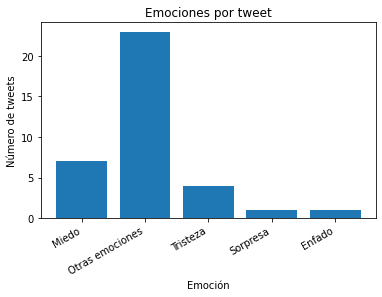

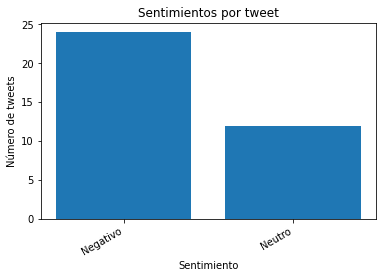

In [ ]:

import matplotlib.pyplot as plt


display('El sentimiento predominante en el tweet objetivo es: '+sentiments_es[target_tweet_main_sentiment]+' ('+str(target_predominand_sent)+')')
display('La emoción predominante en el tweet objetivo es: '+emotions_es[target_tweet_main_emotion]+' ('+str(target_predominand_emot)+')')
print('\n\n')


#Remove items with count 0
sentiments_counter_copy = delete_none(sentiments_counter.copy())
emotions_counter_copy = delete_none(emotions_counter.copy())

# now we will print the emotions and sentiments
###print(emotions_counter)
###print(sentiments_counter)

# now we will plot the graph we will create a figure
# this is for emotions
fig1,ax1=plt.subplots()
ax1.bar(emotions_counter_copy.keys(),emotions_counter_copy.values())
ax1.set_title('Emociones por tweet')
ax1.set_xlabel('Emoción')
ax1.set_ylabel('Número de tweets')
fig1.autofmt_xdate()# to make the words inclined

# this is for sentiments
fig2,ax2=plt.subplots()
ax2.bar(sentiments_counter_copy.keys(),sentiments_counter_copy.values())
ax2.set_title('Sentimientos por tweet')
ax2.set_xlabel('Sentimiento')
ax2.set_ylabel('Número de tweets')
fig2.autofmt_xdate()# to make the words inclined

# will show the plot
plt.show()

In [ ]:
print(STOP)

In [ ]:
################################################################
# Method that generate Stance detection training file for cumbre vieja
################################################################
def generate_stance_detection_file(tweets_dataframe, current_target_text):
    i_less_one_tweet = ''
    only_fakes_threshold = 0.69

    tweets_dataframe['Target'] = 'Megatsuname Cumbre Vieja'
    tweets_dataframe['Stance'] = 'AGAINST'

    #################################################
    #
    for index, row in tweets_dataframe.iterrows():
        i_less_one_tweet = row.text

        #TODO:calc score between tweets
        #Generate embedding
        i_target_tweet_embedding = model.encode(current_target_text)
        i_less_one_embedding = model.encode(i_less_one_tweet)

        #score calc
        cosine_scores_1 = util.pytorch_cos_sim(i_target_tweet_embedding, i_less_one_embedding)

        #Assign the new value
        ##cosine_scores[0][index] = cosine_scores_1[0][0]
        tweets_dataframe.loc[index, "cosine_scores"] = float(cosine_scores_1[0][0])

        if tweets_dataframe.loc[index, "cosine_scores"] > only_fakes_threshold:
          tweets_dataframe.loc[index, 'Stance'] = 'FAVOR'
    #end_for

	  #Copy dataframe sorted by score
    df_aux = tweets_dataframe.sort_values('cosine_scores', ascending=False, inplace=False)
    df_aux.to_csv(BASE_FOLDER+'202122_tweets_StanceDetectionTraining.txt', index=False)
    
#end_method